In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt

from sublimpy import variables
from sublimpy import utils
from sublimpy import tidy

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

from metpy.calc import specific_humidity_from_mixing_ratio
from metpy.units import units
import metpy.constants
import pint_pandas
import pint_xarray
import xarray as xr
import os
import itertools

from tqdm import tqdm
from joblib import Parallel, delayed

from metpy.constants import density_water

# Inputs

In [2]:
ls /Users/elischwat/Development/data/sublimationofsnow/precipitation_masks/

w23_precipitation_mask_0_1_mm.csv   w23_precipitation_mask_0_mm.csv
w23_precipitation_mask_0_25_mm.csv  w23_precipitation_mask_1_mm.csv
w23_precipitation_mask_0_5_mm.csv


In [3]:
sos_data_dir = '/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240307/'

# Choices:
planar_fitted_dir = "/Users/elischwat/Development/data/sublimationofsnow/planar_fit_processed_30min"
filtering_str = 'nodespiking'
FILTER_SNOWFALL = True
snowfall_mask_file = "/Users/elischwat/Development/data/sublimationofsnow/precipitation_masks/w23_precipitation_mask_0_mm.csv"
snowfall_mask_str = '0mm'
PERCENTAGE_DIAG = 36000 

# Constants
PLANAR_FIT = True
start_date = '20221101'
end_date = '20230619'
DATE_FORMAT_STR = '%Y%m%d'
# Threshold number of 20hz samples in a 5 minute average determining if the value
# is replaced with NaN
datelist = pd.date_range(
    dt.datetime.strptime(start_date, DATE_FORMAT_STR),
    dt.datetime.strptime(end_date, DATE_FORMAT_STR),
    freq='d'
).strftime(DATE_FORMAT_STR).tolist()

In [4]:
# Separate out the eddy covariance measurement variable names because they are very repetitive
ec_measurement_suffixes = [
    '1m_ue',    '2m_ue',    '3m_ue',    '10m_ue', 
    '1m_d',     '2m_d',     '3m_d',     '10m_d',
    '1m_uw',    '2m_uw',    '2_5m_uw',  '3m_uw',    '10m_uw', 
    '1m_c',     '2m_c',     '3m_c',     '5m_c',     '10m_c',    '15m_c',    '20m_c'
]

sonic_measurement_prefixes = [
    'u_', 'v_', 'w_', 'tc_', 'spd_', 'dir_', 
    'u_u__', 'v_v__', 'w_w__', 'tc_tc__', 
    'u_w__', 'v_w__', 'u_v__', 
    'u_tc__', 'v_tc__', 'w_tc__', 
    'u_u_u__', 'v_v_v__', 'w_w_w__', 
    'tc_tc_tc__', 
]
irga_measurement_prefixes = [
    'h2o_', 'h2o_h2o__', 'h2o_h2o_h2o__', 'co2_', 'co2_co2__', 'co2_co2_co2__', 
]
sonic_plus_irga_measurement_prefixes = [
    'u_h2o__', 'v_h2o__', 'w_h2o__', 'u_co2__', 'v_co2__', 'w_co2__', 
]
ec_measurement_prefixes = sonic_measurement_prefixes + irga_measurement_prefixes + sonic_plus_irga_measurement_prefixes

ec_variable_names = [
    (prefix + suffix) for prefix in ec_measurement_prefixes for suffix in ec_measurement_suffixes
]

counts_vars = ['counts_' + suffix for suffix in ec_measurement_suffixes]
counts_1_vars = ['counts_' + suffix + '_1' for suffix in ec_measurement_suffixes]
counts_2_vars = ['counts_' + suffix + '_2' for suffix in ec_measurement_suffixes]
irgadiag_vars = ['irgadiag_' + suffix for suffix in ec_measurement_suffixes]
ldiag_vars = ['ldiag_' + suffix for suffix in ec_measurement_suffixes]

diagnostic_variable_names = counts_vars + counts_1_vars + counts_2_vars + irgadiag_vars + ldiag_vars

VARIABLE_NAMES = ec_variable_names + diagnostic_variable_names + [
    # Temperature & Relative Humidity Array 
    'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
    'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'RH_1m_c', 'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
    'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

    # Pressure Sensors
    'P_20m_c',
    'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

    # Blowing snow/FlowCapt Sensors
    'SF_avg_1m_ue', 'SF_avg_2m_ue',

    # Apogee sensors
    "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
    "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
    "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

    # Snow-level temperature arrays (towers D and UW)
    'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
    'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
    
    # Downward/Upward Facing Longwave Radiometers
    'Rpile_out_9m_d','Tcase_out_9m_d',    
    'Rpile_in_9m_d', 'Tcase_in_9m_d',
    'Tcase_uw', 'Rpile_in_uw', 'Rpile_out_uw',
    
    # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
    'Rsw_in_9m_d', 'Rsw_out_9m_d',

    # Snow Pillow SWE
    'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c',

    # Soil Moisture
    'Qsoil_d',

    # Ground heat flux
    'Gsoil_d',
]

# Open and concatenate daily SoS datasets

In [5]:
# all_file_paths = [
#     os.path.join(
#         sos_data_dir,
#         f'isfs_sos_qc_geo_tiltcor_5min_{date}.nc'
#     ) for date in datelist
# ]
# datasets = []
# for file in all_file_paths:
#     ds = xr.open_dataset(file)
#     # this ensures we don't access variables that aren't in this dataset, which would throw an error
#     ds_new = ds[set(ds.data_vars).intersection(VARIABLE_NAMES)]
#     datasets.append(ds_new)

In [6]:
# all_file_paths

In [7]:
# sos_ds = xr.concat(datasets, dim='time')

Ensure time index is evenly spaced by filling in any missing timestamps

In [8]:
# sos_ds = utils.fill_missing_timestamps(sos_ds)

# Save intermediate data product to save time rerunning in the future

In [9]:
# sos_ds.to_netcdf("sos_ds_temp_storage_30min_straightup.cdf")

In [10]:
sos_ds = xr.open_dataset("sos_ds_temp_storage_30min_straightup.cdf")

# Replace flag variables with my calculated aggregated flags
(sonic anemometer and irgason flags)

In [11]:
flag_counts_df = pd.read_parquet("/Users/elischwat/Development/data/sublimationofsnow/sosqc_fast_flagcounts").loc[start_date: end_date]
assert all(sos_ds.time == flag_counts_df.index)

In [12]:
irga_vars = [
    'irgadiag_10m_c',	 'irgadiag_10m_d',	 'irgadiag_10m_ue',	 'irgadiag_10m_uw',	 'irgadiag_15m_c',	 'irgadiag_1m_c',	 'irgadiag_1m_d',	 'irgadiag_1m_ue',	 
    'irgadiag_1m_uw',	 'irgadiag_20m_c',	 'irgadiag_2m_c',	 'irgadiag_3m_c',	 'irgadiag_3m_d',	 'irgadiag_3m_ue',	 'irgadiag_3m_uw',	 'irgadiag_5m_c',	
]

ldiag_vars = [
    'ldiag_10m_c', 'ldiag_10m_d', 'ldiag_10m_ue', 'ldiag_10m_uw', 'ldiag_15m_c', 'ldiag_1m_c', 'ldiag_1m_d', 'ldiag_1m_ue', 
    'ldiag_1m_uw', 'ldiag_20m_c', 'ldiag_2m_c', 'ldiag_3m_c', 'ldiag_3m_d', 'ldiag_3m_ue', 'ldiag_3m_uw', 'ldiag_5m_c',
]

for var in irga_vars + ldiag_vars:
    sos_ds[var] = flag_counts_df[var]

# Resample dataset

## Define dictionary defining the resampling function to use for each variable

Covariances are resampled according to the rules of **Reynold averaging** (https://www.eol.ucar.edu/content/combining-short-term-moments-longer-time-periods).

Meteorological and turbulence measurements (other than covariances) are resampled using the **mean**.

EC count variables are **summed**.

In [13]:
data_vars_processing_dict = {
    'reynolds_average': [
        'u_u__1m_uw',    'v_v__1m_uw',    'w_w__1m_uw',    'u_w__1m_uw',    'v_w__1m_uw',  'u_tc__1m_uw',  'v_tc__1m_uw',   'u_co2__1m_uw', 'u_h2o__1m_uw',  'v_co2__1m_uw', 'v_h2o__1m_uw',   'w_tc__1m_uw',   'w_co2__1m_uw', 'w_h2o__1m_uw',
        'u_u__2m_uw',    'v_v__2m_uw',    'w_w__2m_uw',    'u_w__2m_uw',    'v_w__2m_uw',  'u_tc__2m_uw',  'v_tc__2m_uw',   'u_co2__2m_uw', 'u_h2o__2m_uw',  'v_co2__2m_uw', 'v_h2o__2m_uw',   'w_tc__2m_uw',   'w_co2__2m_uw', 'w_h2o__2m_uw',
        'u_u__2_5m_uw', 'v_v__2_5m_uw',   'w_w__2_5m_uw',  'u_w__2_5m_uw',  'v_w__2_5m_uw','u_tc__2_5m_uw','v_tc__2_5m_uw', 'u_co2__2_5m_uw', 'u_h2o__2_5m_uw','v_h2o__2_5m_uw', 'w_tc__2_5m_uw', 'w_co2__2_5m_uw', 'w_h2o__2_5m_uw',
        'u_u__3m_uw',    'v_v__3m_uw',    'w_w__3m_uw',    'u_w__3m_uw',    'v_w__3m_uw',  'u_tc__3m_uw',  'v_tc__3m_uw',   'u_co2__3m_uw', 'u_h2o__3m_uw',  'v_co2__3m_uw', 'v_h2o__3m_uw',   'w_tc__3m_uw',   'w_co2__3m_uw', 'w_h2o__3m_uw',
        'u_u__10m_uw',   'v_v__10m_uw',   'w_w__10m_uw',   'u_w__10m_uw',   'v_w__10m_uw', 'u_tc__10m_uw', 'v_tc__10m_uw',  'u_co2__10m_uw', 'u_h2o__10m_uw', 'v_co2__10m_uw', 'v_h2o__10m_uw',  'w_tc__10m_uw',  'w_co2__10m_uw', 'w_h2o__10m_uw',
        'u_u__1m_ue',    'v_v__1m_ue',    'w_w__1m_ue',    'u_w__1m_ue',    'v_w__1m_ue',  'u_tc__1m_ue',  'v_tc__1m_ue',   'u_co2__1m_ue', 'u_h2o__1m_ue',  'v_co2__1m_ue', 'v_h2o__1m_ue',   'w_tc__1m_ue',   'w_co2__1m_ue', 'w_h2o__1m_ue',
        'u_u__2m_ue',    'v_v__2m_ue',    'w_w__2m_ue',    'u_w__2m_ue',    'v_w__2m_ue',  'u_tc__2m_ue',  'v_tc__2m_ue',   'u_co2__2m_ue', 'u_h2o__2m_ue',  'v_co2__2m_ue', 'v_h2o__2m_ue',   'w_tc__2m_ue',   'w_co2__2m_ue', 'w_h2o__2m_ue',
        'u_u__3m_ue',    'v_v__3m_ue',    'w_w__3m_ue',    'u_w__3m_ue',    'v_w__3m_ue',  'u_tc__3m_ue',  'v_tc__3m_ue',   'u_co2__3m_ue', 'u_h2o__3m_ue',  'v_co2__3m_ue', 'v_h2o__3m_ue',   'w_tc__3m_ue',   'w_co2__3m_ue', 'w_h2o__3m_ue',
        'u_u__10m_ue',   'v_v__10m_ue',   'w_w__10m_ue',   'u_w__10m_ue',   'v_w__10m_ue', 'u_tc__10m_ue', 'v_tc__10m_ue',  'u_co2__10m_ue', 'u_h2o__10m_ue', 'v_co2__10m_ue', 'v_h2o__10m_ue',  'w_tc__10m_ue',  'w_co2__10m_ue', 'w_h2o__10m_ue',
        'u_u__1m_d',     'v_v__1m_d',     'w_w__1m_d',     'u_w__1m_d',     'v_w__1m_d',   'u_tc__1m_d',   'v_tc__1m_d',    'u_co2__1m_d', 'u_h2o__1m_d',   'v_co2__1m_d', 'v_h2o__1m_d',    'w_tc__1m_d',    'w_co2__1m_d', 'w_h2o__1m_d',
        'u_u__2m_d',     'v_v__2m_d',     'w_w__2m_d',     'u_w__2m_d',     'v_w__2m_d',   'u_tc__2m_d',   'v_tc__2m_d',    'u_co2__2m_d', 'u_h2o__2m_d',   'v_co2__2m_d', 'v_h2o__2m_d',    'w_tc__2m_d',    'w_co2__2m_d', 'w_h2o__2m_d',
        'u_u__3m_d',     'v_v__3m_d',     'w_w__3m_d',     'u_w__3m_d',     'v_w__3m_d',   'u_tc__3m_d',   'v_tc__3m_d',    'u_co2__3m_d', 'u_h2o__3m_d',   'v_co2__3m_d', 'v_h2o__3m_d',    'w_tc__3m_d',    'w_co2__3m_d', 'w_h2o__3m_d',
        'u_u__10m_d',    'v_v__10m_d',    'w_w__10m_d',    'u_w__10m_d',    'v_w__10m_d',  'u_tc__10m_d',  'v_tc__10m_d',   'u_co2__10m_d', 'u_h2o__10m_d',  'v_co2__10m_d', 'v_h2o__10m_d',   'w_tc__10m_d',   'w_co2__10m_d', 'w_h2o__10m_d',
        'u_u__1m_c',     'v_v__1m_c',     'w_w__1m_c',     'u_w__1m_c',     'v_w__1m_c',   'u_tc__1m_c',   'v_tc__1m_c',    'u_co2__1m_c', 'u_h2o__1m_c',   'v_co2__1m_c', 'v_h2o__1m_c',    'w_tc__1m_c',    'w_co2__1m_c', 'w_h2o__1m_c',
        'u_u__2m_c',     'v_v__2m_c',     'w_w__2m_c',     'u_w__2m_c',     'v_w__2m_c',   'u_tc__2m_c',   'v_tc__2m_c',    'u_co2__2m_c', 'u_h2o__2m_c',   'v_co2__2m_c', 'v_h2o__2m_c',    'w_tc__2m_c',    'w_co2__2m_c', 'w_h2o__2m_c',
        'u_u__3m_c',     'v_v__3m_c',     'w_w__3m_c',     'u_w__3m_c',     'v_w__3m_c',   'u_tc__3m_c',   'v_tc__3m_c',    'u_co2__3m_c', 'u_h2o__3m_c',   'v_co2__3m_c', 'v_h2o__3m_c',    'w_tc__3m_c',    'w_co2__3m_c', 'w_h2o__3m_c',
        'u_u__5m_c',     'v_v__5m_c',     'w_w__5m_c',     'u_w__5m_c',     'v_w__5m_c',   'u_tc__5m_c',   'v_tc__5m_c',    'u_co2__5m_c', 'u_h2o__5m_c',   'v_co2__5m_c', 'v_h2o__5m_c',    'w_tc__5m_c',    'w_co2__5m_c', 'w_h2o__5m_c',
        'u_u__10m_c',    'v_v__10m_c',    'w_w__10m_c',    'u_w__10m_c',    'v_w__10m_c',  'u_tc__10m_c',  'v_tc__10m_c',   'u_co2__10m_c', 'u_h2o__10m_c',  'v_co2__10m_c', 'v_h2o__10m_c',   'w_tc__10m_c',   'w_co2__10m_c', 'w_h2o__10m_c',
        'u_u__15m_c',    'v_v__15m_c',    'w_w__15m_c',    'u_w__15m_c',    'v_w__15m_c',  'u_tc__15m_c',  'v_tc__15m_c',   'u_co2__15m_c', 'u_h2o__15m_c',  'v_co2__15m_c', 'v_h2o__15m_c',   'w_tc__15m_c',   'w_co2__15m_c', 'w_h2o__15m_c',
        'u_u__20m_c',    'v_v__20m_c',    'w_w__20m_c',    'u_w__20m_c',    'v_w__20m_c',  'u_tc__20m_c',  'v_tc__20m_c',   'u_co2__20m_c', 'u_h2o__20m_c',  'v_co2__20m_c', 'v_h2o__20m_c',   'w_tc__20m_c',   'w_co2__20m_c', 'w_h2o__20m_c',
    ],
    'average': [
        # Sonic anemometer data
        'co2_1m_uw', 'h2o_1m_uw' ,       'tc_1m_uw',     'spd_1m_uw',    'u_1m_uw',  'v_1m_uw',   'w_1m_uw',  
        'co2_3m_uw', 'h2o_3m_uw' ,       'tc_3m_uw',     'spd_3m_uw',    'u_3m_uw',  'v_3m_uw',   'w_3m_uw',  
        'co2_10m_uw', 'h2o_10m_uw' ,      'tc_10m_uw',    'spd_10m_uw',   'u_10m_uw', 'v_10m_uw',  'w_10m_uw',  
        'co2_1m_ue', 'h2o_1m_ue' ,       'tc_1m_ue',     'spd_1m_ue',    'u_1m_ue',  'v_1m_ue',   'w_1m_ue',  
        'co2_3m_ue', 'h2o_3m_ue' ,       'tc_3m_ue',     'spd_3m_ue',    'u_3m_ue',  'v_3m_ue',   'w_3m_ue',  
        'co2_10m_ue', 'h2o_10m_ue' ,      'tc_10m_ue',    'spd_10m_ue',   'u_10m_ue', 'v_10m_ue',  'w_10m_ue',  
        'co2_1m_d', 'h2o_1m_d' ,        'tc_1m_d',      'spd_1m_d',     'u_1m_d',   'v_1m_d',    'w_1m_d',  
        'co2_3m_d', 'h2o_3m_d' ,        'tc_3m_d',      'spd_3m_d',     'u_3m_d',   'v_3m_d',    'w_3m_d',  
        'co2_10m_d', 'h2o_10m_d' ,       'tc_10m_d',     'spd_10m_d',    'u_10m_d',  'v_10m_d',   'w_10m_d',  
        'co2_1m_c', 'h2o_1m_c' ,        'tc_1m_c',      'spd_1m_c',     'u_1m_c',   'v_1m_c',    'w_1m_c',  
        'co2_2m_c', 'h2o_2m_c' ,        'tc_2m_c',      'spd_2m_c',     'u_2m_c',   'v_2m_c',    'w_2m_c',  
        'co2_3m_c', 'h2o_3m_c' ,        'tc_3m_c',      'spd_3m_c',     'u_3m_c',   'v_3m_c',    'w_3m_c',  
        'co2_5m_c', 'h2o_5m_c' ,        'tc_5m_c',      'spd_5m_c',     'u_5m_c',   'v_5m_c',    'w_5m_c',  
        'co2_10m_c', 'h2o_10m_c' ,       'tc_10m_c',     'spd_10m_c',    'u_10m_c',  'v_10m_c',   'w_10m_c',  
        'co2_15m_c', 'h2o_15m_c' ,       'tc_15m_c',     'spd_15m_c',    'u_15m_c',  'v_15m_c',   'w_15m_c',  
        'co2_20m_c', 'h2o_20m_c' ,       'tc_20m_c',     'spd_20m_c',    'u_20m_c',  'v_20m_c',   'w_20m_c',  

        # Temperature & Relative Humidity Array 
        'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c',
        'T_11m_c', 'T_12m_c', 'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

        'RH_1m_c', 'RH_2m_c', 'RH_3m_c', 'RH_4m_c', 'RH_5m_c', 'RH_6m_c', 'RH_7m_c', 'RH_8m_c', 'RH_9m_c', 'RH_10m_c',
        'RH_11m_c','RH_12m_c','RH_13m_c','RH_14m_c','RH_15m_c','RH_16m_c','RH_17m_c','RH_18m_c','RH_19m_c','RH_20m_c',

        # Pressure Sensors
        'P_20m_c',
        'P_10m_c', 'P_10m_d', 'P_10m_uw', 'P_10m_ue',

        # Blowing snow/FlowCapt Sensors
        'SF_avg_1m_ue', 'SF_avg_2m_ue',

        # Apogee sensors
        "Vtherm_c", "Vtherm_d", "Vtherm_ue", "Vtherm_uw", 
        "Vpile_c", "Vpile_d", "Vpile_ue", "Vpile_uw",
        "IDir_c", "IDir_d", "IDir_ue", "IDir_uw",

        # Snow-level temperature arrays (towers D and UW)
        'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d',
        'Tsnow_0_4m_uw', 'Tsnow_0_5m_uw', 'Tsnow_0_6m_uw', 'Tsnow_0_7m_uw', 'Tsnow_0_8m_uw', 'Tsnow_0_9m_uw', 'Tsnow_1_0m_uw', 'Tsnow_1_1m_uw', 'Tsnow_1_2m_uw', 'Tsnow_1_3m_uw', 'Tsnow_1_4m_uw', 'Tsnow_1_5m_uw',
        
        # Downward Facing Longwave Radiometer (tower D) - for measuring snow surface temperature
        'Rpile_out_9m_d',
        'Tcase_out_9m_d',    
        # Upward Facing Longwave Radiometer (tower D)
        'Rpile_in_9m_d',
        'Tcase_in_9m_d',
        # Downward Facing Longwave Radiometer (tower UW) - for measuring snow surface temperature
        'Tcase_uw', 'Rpile_in_uw', 'Rpile_out_uw',
        
        # Upward facing shortwave radiometer (tower D) - for measuring incoming solar radiation!
        'Rsw_in_9m_d',
        'Rsw_out_9m_d',

        # Snow Pillow SWE
        'SWE_p1_c', 'SWE_p2_c', 'SWE_p3_c', 'SWE_p4_c',

        # Soil Moisture
        'Qsoil_d',

        # Soil Moisture
        'Gsoil_d',
    ],
    'median' : [
        'dir_1m_uw',    
        'dir_3m_uw',    
        'dir_10m_uw',   
        'dir_1m_ue',    
        'dir_3m_ue',    
        'dir_10m_ue',   
        'dir_1m_d',     
        'dir_3m_d',     
        'dir_10m_d',    
        'dir_1m_c',     
        'dir_2m_c',     
        'dir_3m_c',     
        'dir_5m_c',     
        'dir_10m_c',    
        'dir_15m_c',    
        'dir_20m_c',    
    ],
    'sum' : [
        # Counts of UNflagged instantaneous (20hz) eddy covariance measurements
        'counts_1m_c',    'counts_1m_c_1',    'counts_1m_c_2',    
        'counts_2m_c',    'counts_2m_c_1',    'counts_2m_c_2',    
        'counts_3m_c',    'counts_3m_c_1',    'counts_3m_c_2',    
        'counts_5m_c',    'counts_5m_c_1',    'counts_5m_c_2',    
        'counts_10m_c',   'counts_10m_c_1',   'counts_10m_c_2',   
        'counts_15m_c',   'counts_15m_c_1',   'counts_15m_c_2',   
        'counts_20m_c',   'counts_20m_c_1',   'counts_20m_c_2',   
        'counts_1m_uw',   'counts_1m_uw_1',   'counts_1m_uw_2',   
        'counts_3m_uw',   'counts_3m_uw_1',   'counts_3m_uw_2',   
        'counts_10m_uw',  'counts_10m_uw_1',  'counts_10m_uw_2',  
        'counts_1m_ue',   'counts_1m_ue_1',   'counts_1m_ue_2',   
        'counts_3m_ue',   'counts_3m_ue_1',   'counts_3m_ue_2',   
        'counts_10m_ue',  'counts_10m_ue_1',  'counts_10m_ue_2',  
        'counts_1m_d',    'counts_1m_d_1',    'counts_1m_d_2',    
        'counts_3m_d',    'counts_3m_d_1',    'counts_3m_d_2',    
        'counts_10m_d',   'counts_10m_d_1',   'counts_10m_d_2',   

        # Counts of FLAGGED 20hz measurements 
        'irgadiag_1m_c',    'ldiag_1m_c',
        'irgadiag_2m_c',    'ldiag_2m_c',
        'irgadiag_3m_c',    'ldiag_3m_c',
        'irgadiag_5m_c',    'ldiag_5m_c',
        'irgadiag_10m_c',   'ldiag_10m_c',
        'irgadiag_15m_c',   'ldiag_15m_c',
        'irgadiag_20m_c',   'ldiag_20m_c',
        'irgadiag_1m_uw',   'ldiag_1m_uw',
        'irgadiag_3m_uw',   'ldiag_3m_uw',
        'irgadiag_10m_uw',  'ldiag_10m_uw',
        'irgadiag_1m_ue',   'ldiag_1m_ue',
        'irgadiag_3m_ue',   'ldiag_3m_ue',
        'irgadiag_10m_ue',  'ldiag_10m_ue',
        'irgadiag_1m_d',    'ldiag_1m_d',
        'irgadiag_3m_d',    'ldiag_3m_d',
        'irgadiag_10m_d',   'ldiag_10m_d',
    ]
}

## Define function for resampling covariances

In [14]:
def separate_covariance_variable_name(cov_name):
    """Get the names of the two mean variables associated with a covariance variable. Built to use
    with SOS datasets. For example, one might provide `w_h2o__3m_c` and this function will return
    `w_3m_c` and `h2o_3m_c`.

    Args:
        cov_name (str): name of variable that you want to separate into the two names of the 
        asssociated mean variables.

    Returns:
        var1, var 2 (str, str): two strings with the names of the two mean variables
    """
    [first_parts, second_part] = cov_name.split('__')
    [var1, var2] = first_parts.split('_')
    [var1, var2] = [
        var1 +'_' + second_part,
        var2 +'_' + second_part,
    ]
    return var1, var2

def resample_moment(df, cov, mean1, mean2, new_frequency, n_in_new_re_length, skipna=True):
    """Combines moments into longer time periods, using reynolds averaging. Built to use with SOS 
    datasets. Resampling covariances which have been calculated for a specific Reynolds
    averaging length (e.g. the SOS datasets are averaged to 5minutes), you need both the mean
    values and covariance. For example, the variable `w_h2o__3m_c` is associated with mean values
    `w_3m_c` and `h2o_3m_c`. To reasmple `w_h2o__3m_c` to another averaging length, we need the three
    variables.

    Args:
        df (pd.Dataframe): Dataframe containing the three columns required for calculations (contains)
                    the names supplied as parameters `cov`, `mean1`, and `mean2`.
        cov (str): Name of covariance variable to resample using Reynolds averaing
        mean1 (str): Name of one of the two mean variables associated with `cov`
        mean2 (str): Name of the other mean variable associated with `cov`
        new_frequency (str): String interpretable by pandas/xarray that describes the reynolds length you 
            are resampling to. EG: '60Min'
        n_in_new_re_length (_type_): Number of 5 minute intervals that fit in the new_frequency. E.G. for
            new_frequency='60Min', you would provide 12.
        skipna (bool, optional): Whether to skip NaNs when calculating the new variables. Providing True
            will allow more moments to be calculated, but those moments may be inaccurate/non-representative.
            Providing False will result in more missing data.

    Returns:
        pd.DataFrame: Dataframe with resampled data.
    """
    return pd.DataFrame({
            cov: df.groupby(pd.Grouper(freq=new_frequency)).apply(
                lambda row: 
                    (1/n_in_new_re_length)*(row[cov] + row[mean1]*row[mean2]).sum(skipna=skipna)
                    - (
                        (1/n_in_new_re_length)*row[mean1].sum(skipna=skipna)
                        * (1/n_in_new_re_length)*row[mean2].sum(skipna=skipna)
                    )
            )
        })

def resample(ds, new_frequency, n_in_new_re_length, skipna=True):
    """Resample SOS xarray datasets, applying the proper aggregation function
    for different variables. Some are resampled by taking the mean, some by 
    summing, and others by Reynolds averaging. 
    """
    # Resample data vars that need to be averaged (plain old averaging)
    # Use built in xarray functionality
    resampled_averages = ds[
        data_vars_processing_dict['average']
    ].to_dataframe().resample(new_frequency).mean().to_xarray()

    resampled_medians = ds[
        data_vars_processing_dict['median']
    ].to_dataframe().resample(new_frequency).median().to_xarray()
    
    # Resample data vars that need to be summed
    # Use built in xarray functionality
    resampled_sums = ds[
        data_vars_processing_dict['sum']
    ].to_dataframe().resample(new_frequency).sum().to_xarray()
    
    # Resample data vars that need to be summed using the rules of Reynolds Averaging
    # Use our custom function defined above
    resampled_reynolds_averages_list = []
    def split_covariance_name_and_resample(name):
        mean_var1, mean_var2 = separate_covariance_variable_name(name)
        resampled = resample_moment(
            ds[[mean_var1, mean_var2, name]].to_dataframe(), 
            name, 
            mean_var1, 
            mean_var2, 
            new_frequency, 
            n_in_new_re_length, 
            skipna=skipna
        )
        return resampled.to_xarray()
    resampled_reynolds_averages_list =  Parallel(n_jobs = 8)(
        delayed(split_covariance_name_and_resample)(name) 
        for name in tqdm(data_vars_processing_dict['reynolds_average'])
    )
    
    new_ds = xr.merge(
        [
            resampled_sums, 
            resampled_medians,
            resampled_averages
        ] + resampled_reynolds_averages_list
    )

    ## Copy attributes from the original dataset
    new_ds.attrs = ds.attrs
    for var in new_ds:
        new_ds[var].attrs = ds[var].attrs
    return new_ds

## Resample variables

In [15]:
sos_ds30min = resample(sos_ds, '30Min', 6, skipna=True)

  9%|▊         | 24/279 [00:03<00:37,  6.76it/s]/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 279/279 [01:02<00:00,  4.47it/s]


In [16]:
sos_ds5min = sos_ds
sos_ds = sos_ds30min

# Replace fluxes with planar fitted fluxes

In [17]:
src = sos_ds[[
    'w_1m_c',   'w_2m_c','w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c',
    'w_1m_ue',  'w_3m_ue','w_10m_ue',
    'w_1m_uw',  'w_3m_uw','w_10m_uw',
    'w_1m_d',   'w_3m_d','w_10m_d',
]]
src = tidy.get_tidy_dataset(src, list(src.data_vars))
src = utils.modify_df_timezone(src, 'UTC', 'US/Mountain')
alt.Chart(
    src
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Wind speed (m/s)'),
    alt.Color('tower:N'),
    alt.Facet('height:O', columns=4),
    tooltip='variable',
).properties(width = 125, height = 125, title=    'Streamwise').display(renderer='svg')

alt.Chart(...)

In [18]:
planar_fitted_data_df = pd.read_parquet(planar_fitted_dir)


In [19]:
if PLANAR_FIT:
    planar_fitted_data_df = planar_fitted_data_df[[c for c in planar_fitted_data_df.columns if c.endswith('_fit')]]
    planar_fitted_data_df.columns = [c.replace('_fit', '') for c in planar_fitted_data_df.columns]
    planar_fitted_data_df = planar_fitted_data_df.loc[ start_date : end_date ]
    planar_fitted_data_df.index = planar_fitted_data_df.index - dt.timedelta(minutes=15)
    planar_fitted_ds = planar_fitted_data_df.to_xarray()
    sos_ds = sos_ds.assign(planar_fitted_ds)

In [20]:
src = sos_ds[[
    'w_1m_c',   'w_2m_c',   'w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c',
    'w_1m_ue',  'w_3m_ue',  'w_10m_ue',
    'w_1m_uw',  'w_3m_uw',  'w_10m_uw',
    'w_1m_d',   'w_3m_d',   'w_10m_d',
]]
src = tidy.get_tidy_dataset(src, list(src.data_vars))
src = utils.modify_df_timezone(src, 'UTC', 'US/Mountain')
alt.Chart(
    src
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Wind speed (m/s)').scale(domain = [-0.02,0.02]),
    alt.Color('tower:N'),
    alt.Facet('height:O', columns=4),
    tooltip='variable',
).properties(width = 125, height = 125, title='Streamwise').display(renderer='svg')

alt.Chart(...)

In [21]:
alt.Chart(
    src
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q').title('Wind speed (m/s)').scale(domain = [-0.02,0.02]),
    alt.Facet('tower:N', columns=4),
    alt.Color('height:O').scale(scheme='turbo'),
    tooltip='variable',
).properties(width = 125, height = 125, title='Streamwise').display(renderer='svg')

alt.Chart(...)

# Remove instrument-flagged data

Based on Stiperski and Rotach (2016, http://link.springer.com/10.1007/s10546-015-0103-z), who recommend the following steps as minimum quality criteria:

1. The sonic diagnostic flag was set high (malfunctioning of the instrument) inside the averaging period. 
2. KH20 voltage fell below 5 mV (indication of condensation occurring on the KH20 window).
3. Skewness of temperature and wind components fell outside the [-2, 2] range, following Vickers and Mahrt (1997).
4. Kurtosis of temperature and wind components was >8, following Vickers and Mahrt (1997).

We only implement number #2 and #3. We tried implementing #1, using the ldiag flag to remove sonic data, but it removed a lot of data, and, without using high rate data, we't cannot filter based on a "high" diagnostic flag, we can only filtering using the aggregate of all the flags (i.e. ldiag > 0). The 4th moments are not included in the 5-minute averages, so we cannot implement #4 without using the high rate data.

## Set bad Irga measurements to NaN

The NCAR report recommends all Irga-related measurements be set to NaN when irgadiag is non-zero.  They did this for some but not all of the data.

In [22]:
print('h2o_flux_var', 'irgadiag_var', 'old_nan_count_badirga', 'new_nan_count_badirga', 'old_mean', 'new_mean')
var_ls = []
old_nan_count_badirga_ls = []
new_nan_count_badirga_ls = []
old_mean_ls = []
new_mean_ls = []
old_median_ls = []
new_median_ls = []
for suffix in ec_measurement_suffixes:
    h2o_flux_var = 'w_h2o__' + suffix
    irgadiag_var = 'irgadiag_' + suffix

    if irgadiag_var in sos_ds.variables and h2o_flux_var in sos_ds.variables:
        old_nan_count_badirga = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
        old_mean = sos_ds[h2o_flux_var].mean().item()
        old_median = sos_ds[h2o_flux_var].median().item()

        for prefix in ec_measurement_prefixes:
            var = prefix + suffix
            if var in sos_ds:
                sos_ds[var] = sos_ds[var].where(sos_ds[irgadiag_var] <= PERCENTAGE_DIAG)
        # for prefix in [
        #     'h2o_', 'h2o_h2o__', 'u_h2o__', 'v_h2o__', 'w_h2o__',
        #     # I'M NOT SURE I WANT TO REMOVE THESE w_ MEASUREMENTS BUT I"M CURIOUS WHAT HAPPENS IF I DO
        #     'w_',
        # ]:


        new_nan_count_badirga = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
        new_mean = sos_ds[h2o_flux_var].mean().item()
        new_median = sos_ds[h2o_flux_var].median().item()
        print(h2o_flux_var, irgadiag_var, old_nan_count_badirga, new_nan_count_badirga, round(old_mean,6), round(new_mean,6))
        var_ls.append(h2o_flux_var)
        old_nan_count_badirga_ls.append(old_nan_count_badirga)
        new_nan_count_badirga_ls.append(new_nan_count_badirga)
        old_mean_ls.append(old_mean)
        new_mean_ls.append(new_mean)
        old_median_ls.append(old_median)
        new_median_ls.append(new_median)
    else:
        print(f"Variable {h2o_flux_var} or {irgadiag_var} not in dataset.")
        var_ls.append(h2o_flux_var)
        old_nan_count_badirga_ls.append(np.nan)
        new_nan_count_badirga_ls.append(np.nan)
        old_mean_ls.append(np.nan)
        new_mean_ls.append(np.nan)
        old_median_ls.append(np.nan)
        new_median_ls.append(np.nan)

h2o_flux_var irgadiag_var old_nan_count_badirga new_nan_count_badirga old_mean new_mean
w_h2o__1m_ue irgadiag_1m_ue 6999 6999 0.010311 0.010311
Variable w_h2o__2m_ue or irgadiag_2m_ue not in dataset.
w_h2o__3m_ue irgadiag_3m_ue 977 977 0.007198 0.007198
w_h2o__10m_ue irgadiag_10m_ue 793 793 0.006935 0.006935
w_h2o__1m_d irgadiag_1m_d 6775 6775 0.009535 0.009535
Variable w_h2o__2m_d or irgadiag_2m_d not in dataset.
w_h2o__3m_d irgadiag_3m_d 996 996 0.007104 0.007104
w_h2o__10m_d irgadiag_10m_d 879 879 0.007042 0.007042
w_h2o__1m_uw irgadiag_1m_uw 7735 7735 0.012074 0.012074
Variable w_h2o__2m_uw or irgadiag_2m_uw not in dataset.
Variable w_h2o__2_5m_uw or irgadiag_2_5m_uw not in dataset.
w_h2o__3m_uw irgadiag_3m_uw 934 934 0.007292 0.007292
w_h2o__10m_uw irgadiag_10m_uw 1118 1118 0.007143 0.007143
w_h2o__1m_c irgadiag_1m_c 4781 4781 0.00782 0.00782
w_h2o__2m_c irgadiag_2m_c 677 677 0.006724 0.006724
w_h2o__3m_c irgadiag_3m_c 679 679 0.007045 0.007045
w_h2o__5m_c irgadiag_5m_c 1063 1063 

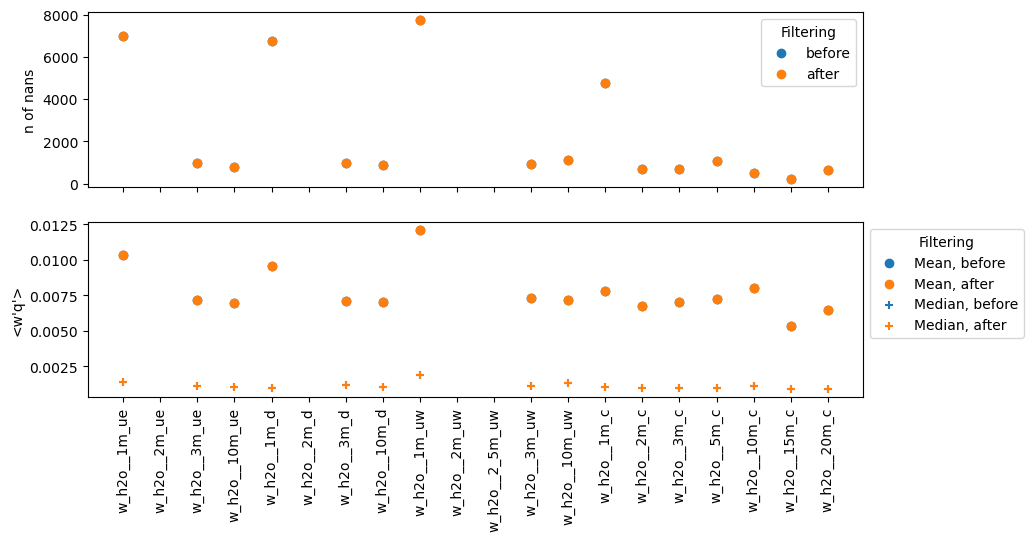

In [23]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(10,5))
axes[0].scatter(var_ls, old_nan_count_badirga_ls, label = 'before', color='tab:blue')
axes[0].set_ylabel("n of nans")
axes[0].scatter(var_ls, new_nan_count_badirga_ls, label = 'after', color='tab:orange')

axes[1].scatter(var_ls, old_mean_ls, label = 'Mean, before', color='tab:blue')
axes[1].set_ylabel("<w'q'>")
axes[1].scatter(var_ls, new_mean_ls, label = 'Mean, after', color='tab:orange')

axes[1].scatter(var_ls, old_median_ls, label = 'Median, before', marker='+', color='tab:blue')
axes[1].set_ylabel("<w'q'>")
axes[1].scatter(var_ls, new_median_ls, label = 'Median, after', marker='+', color='tab:orange')

for ax in axes:
    ax.tick_params(rotation=90, axis='x')
    ax.legend(title='Filtering', bbox_to_anchor=(1,1))

## Set bad Sonic measurements to Nan

In [24]:
print('h2o_flux_var', 'ldiag_var', 'old_nan_count_badsonic', 'new_nan_count_badsonic', 'old_mean', 'new_mean')

var_ls = []
old_nan_count_badsonic_ls = []
new_nan_count_badsonic_ls = []
old_mean_ls = []
new_mean_ls = []
for suffix in ec_measurement_suffixes:
    w_var = 'w_' + suffix
    h2o_flux_var = 'w_h2o__' + suffix
    sonicdiag_var = 'ldiag_' + suffix

    if h2o_flux_var in sos_ds.variables and sonicdiag_var in sos_ds.variables:
        old_nan_count_badsonic = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
        old_mean = sos_ds[h2o_flux_var].mean().item()
        
        # sos_ds[h2o_flux_var] = sos_ds[h2o_flux_var].where(sos_ds[sonicdiag_var] == 0)
        # sos_ds[w_var] = sos_ds[w_var].where(sos_ds[sonicdiag_var] == 0)
        for prefix in ec_measurement_prefixes:
            var = prefix + suffix
            if var in sos_ds:
                sos_ds[var] = sos_ds[var].where(sos_ds[sonicdiag_var] <= PERCENTAGE_DIAG)

        new_nan_count_badsonic = (np.isnan(sos_ds[h2o_flux_var])).sum().item()
        new_mean = sos_ds[h2o_flux_var].mean().item()
        print(h2o_flux_var, sonicdiag_var, old_nan_count_badsonic, new_nan_count_badsonic, round(old_mean,6), round(new_mean,6))
        var_ls.append(h2o_flux_var)
        old_nan_count_badsonic_ls.append(old_nan_count_badsonic)
        new_nan_count_badsonic_ls.append(new_nan_count_badsonic)
        old_mean_ls.append(old_mean)
        new_mean_ls.append(new_mean)
    else:
        print(f"Variable {h2o_flux_var} or {sonicdiag_var} not in dataset.")
        var_ls.append(h2o_flux_var)
        old_nan_count_badsonic_ls.append(np.nan)
        new_nan_count_badsonic_ls.append(np.nan)
        old_mean_ls.append(np.nan)
        new_mean_ls.append(np.nan)

h2o_flux_var ldiag_var old_nan_count_badsonic new_nan_count_badsonic old_mean new_mean
w_h2o__1m_ue ldiag_1m_ue 6999 6999 0.010311 0.010311
Variable w_h2o__2m_ue or ldiag_2m_ue not in dataset.
w_h2o__3m_ue ldiag_3m_ue 977 977 0.007198 0.007198
w_h2o__10m_ue ldiag_10m_ue 793 793 0.006935 0.006935
w_h2o__1m_d ldiag_1m_d 6775 6775 0.009535 0.009535
Variable w_h2o__2m_d or ldiag_2m_d not in dataset.
w_h2o__3m_d ldiag_3m_d 996 996 0.007104 0.007104
w_h2o__10m_d ldiag_10m_d 879 879 0.007042 0.007042
w_h2o__1m_uw ldiag_1m_uw 7735 7735 0.012074 0.012074
Variable w_h2o__2m_uw or ldiag_2m_uw not in dataset.
Variable w_h2o__2_5m_uw or ldiag_2_5m_uw not in dataset.
w_h2o__3m_uw ldiag_3m_uw 934 934 0.007292 0.007292
w_h2o__10m_uw ldiag_10m_uw 1118 1118 0.007143 0.007143
w_h2o__1m_c ldiag_1m_c 4781 4781 0.00782 0.00782
w_h2o__2m_c ldiag_2m_c 677 677 0.006724 0.006724
w_h2o__3m_c ldiag_3m_c 679 679 0.007045 0.007045
w_h2o__5m_c ldiag_5m_c 1063 1063 0.007252 0.007252
w_h2o__10m_c ldiag_10m_c 504 504 0

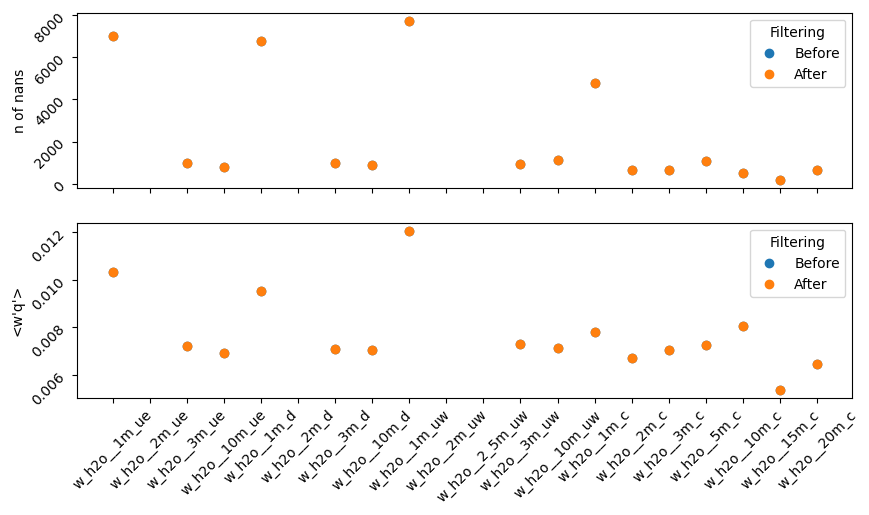

In [25]:
fig, axes = plt.subplots(2,1, sharex=True, figsize=(10,5))
axes[0].scatter(var_ls, old_nan_count_badsonic_ls, label = 'Before')
axes[0].set_ylabel("n of nans")
axes[0].scatter(var_ls, new_nan_count_badsonic_ls, label = 'After')

axes[1].scatter(var_ls, old_mean_ls, label = 'Before')
axes[1].set_ylabel("<w'q'>")
axes[1].scatter(var_ls, new_mean_ls, label = 'After')

for ax in axes:
    ax.tick_params(rotation=45)
    ax.legend(title='Filtering')

In [26]:
nan_counts_df = pd.DataFrame({
    'variable':                     var_ls,
    'n':                            len(sos_ds.time),
    'original nan count':           old_nan_count_badirga_ls, 
    'nans after bad irga removed':  new_nan_count_badirga_ls, 
    'nans after bad sonic removed': new_nan_count_badsonic_ls, 
})
limited_nan_counts_df = nan_counts_df[ 
    (~nan_counts_df.variable.str.contains('__1m_'))
    
    &
    (~nan_counts_df.variable.str.contains('__2_5m_'))
]
limited_nan_counts_df

,variable,n,original nan count,nans after bad irga removed,nans after bad sonic removed
1,w_h2o__2m_ue,11088,NaN,NaN,NaN
2,w_h2o__3m_ue,11088,977.0,977.0,977.0
3,w_h2o__10m_ue,11088,793.0,793.0,793.0
5,w_h2o__2m_d,11088,NaN,NaN,NaN
6,w_h2o__3m_d,11088,996.0,996.0,996.0
7,w_h2o__10m_d,11088,879.0,879.0,879.0
9,w_h2o__2m_uw,11088,NaN,NaN,NaN
11,w_h2o__3m_uw,11088,934.0,934.0,934.0
12,w_h2o__10m_uw,11088,1118.0,1118.0,1118.0
14,w_h2o__2m_c,11088,677.0,677.0,677.0


In [27]:
limited_nan_counts_df['Data removed by EC150 flag'] = limited_nan_counts_df['nans after bad irga removed'] - limited_nan_counts_df['original nan count']
limited_nan_counts_df['Data removed by CSAT3 flag'] = limited_nan_counts_df['nans after bad sonic removed'] - limited_nan_counts_df['nans after bad irga removed']
limited_nan_counts_df[[
    'variable',
    'n',
    'Data removed by EC150 flag',
    'Data removed by CSAT3 flag'
]]

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77483/1657379086.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_nan_counts_df['Data removed by EC150 flag'] = limited_nan_counts_df['nans after bad irga removed'] - limited_nan_counts_df['original nan count']
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77483/1657379086.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_nan_counts_df['Data removed by CSAT3 flag'] = limited_nan_counts_df['nans after bad sonic remov

,variable,n,Data removed by EC150 flag,Data removed by CSAT3 flag
1,w_h2o__2m_ue,11088,NaN,NaN
2,w_h2o__3m_ue,11088,0.0,0.0
3,w_h2o__10m_ue,11088,0.0,0.0
5,w_h2o__2m_d,11088,NaN,NaN
6,w_h2o__3m_d,11088,0.0,0.0
7,w_h2o__10m_d,11088,0.0,0.0
9,w_h2o__2m_uw,11088,NaN,NaN
11,w_h2o__3m_uw,11088,0.0,0.0
12,w_h2o__10m_uw,11088,0.0,0.0
14,w_h2o__2m_c,11088,0.0,0.0


In [28]:
limited_nan_counts_df.dropna()

,variable,n,original nan count,nans after bad irga removed,nans after bad sonic removed,Data removed by EC150 flag,Data removed by CSAT3 flag
2,w_h2o__3m_ue,11088,977.0,977.0,977.0,0.0,0.0
3,w_h2o__10m_ue,11088,793.0,793.0,793.0,0.0,0.0
6,w_h2o__3m_d,11088,996.0,996.0,996.0,0.0,0.0
7,w_h2o__10m_d,11088,879.0,879.0,879.0,0.0,0.0
11,w_h2o__3m_uw,11088,934.0,934.0,934.0,0.0,0.0
12,w_h2o__10m_uw,11088,1118.0,1118.0,1118.0,0.0,0.0
14,w_h2o__2m_c,11088,677.0,677.0,677.0,0.0,0.0
15,w_h2o__3m_c,11088,679.0,679.0,679.0,0.0,0.0
16,w_h2o__5m_c,11088,1063.0,1063.0,1063.0,0.0,0.0
17,w_h2o__10m_c,11088,504.0,504.0,504.0,0.0,0.0


In [29]:
src = sos_ds[['SF_avg_1m_ue', 'SF_avg_2m_ue', 'ldiag_3m_c']].to_dataframe().reset_index()
src['SF_avg_ue'] = src['SF_avg_1m_ue'] + src['SF_avg_2m_ue']
src = utils.modify_df_timezone(src, 'UTC', 'US/Mountain')
src['on Dec 21/22'] = (src.time.dt.date == dt.date(2022,12,22)) | (src.time.dt.date == dt.date(2022,12,21))
src = src.query("SF_avg_ue > 0")
rule = alt.Chart().transform_calculate(rule = '0.1').mark_rule(strokeDash=[2,2]).encode(y='rule:Q')
bad_sonic_data = (
    rule + alt.Chart(src).mark_circle(size=10).encode(
        alt.X("SF_avg_ue").title("Blowing snow flux (g/m^2/s)").scale(type='log'),
        alt.Y("ldiag_3m_c").title(["Fraction of 20hz sonic anemometer", "measurements flagged (Tower C, 3m)"]),
        alt.Color("on Dec 21/22:N")
    ).properties(width=200, height=200)
).configure_axis(grid=False).configure_legend(columns=2, orient='top')
bad_sonic_data.save("bad_sonic_data.png", ppi=200)
display(bad_sonic_data)

alt.LayerChart(...)

In [30]:
src = sos_ds[['RH_3m_c', 'SF_avg_1m_ue', 'SF_avg_2m_ue', 'ldiag_3m_c', 'ldiag_5m_c', 'ldiag_10m_c', 'ldiag_15m_c', 'ldiag_20m_c']].to_dataframe().reset_index()
src['SF_avg_ue'] = src['SF_avg_1m_ue'] + src['SF_avg_2m_ue']
src = utils.modify_df_timezone(src, 'UTC', 'US/Mountain')
src['on Dec 21/22'] = (src.time.dt.date == dt.date(2022,12,22)) | (src.time.dt.date == dt.date(2022,12,21))
src = src.query("SF_avg_ue == 0")
rule = alt.Chart().transform_calculate(rule = '9000').mark_rule(strokeDash=[2,2]).encode(y='rule:Q')
bad_sonic_data = (
    alt.Chart(src).transform_fold([
        'ldiag_3m_c', 'ldiag_5m_c', 'ldiag_10m_c', 'ldiag_15m_c', 'ldiag_20m_c'
    ]).mark_circle(size=10).encode(
        alt.X("RH_3m_c").title("RH (%)"),
        alt.Y("value:Q").title(["Fraction of 20hz sonic anemometer", "measurements flagged (Tower C, 3m)"]),
        alt.Color("on Dec 21/22:N"),
        alt.Column('key:N').sort(['ldiag_3m_c', 'ldiag_5m_c', 'ldiag_10m_c', 'ldiag_15m_c', 'ldiag_20m_c'])
    ).properties(width=200, height=200)
).configure_axis(grid=False).configure_legend(columns=2, orient='top')
bad_sonic_data.save("bad_sonic_data.png", ppi=200)
display(bad_sonic_data)

alt.Chart(...)

In [31]:
display(src.query("ldiag_3m_c > 0.1")['on Dec 21/22'].value_counts())

on Dec 21/22
False    895
True       5
Name: count, dtype: int64

In [32]:
src = sos_ds[['RH_3m_c', 'RH_5m_c', 'RH_10m_c', 'RH_15m_c', 'RH_20m_c', 
                'irgadiag_3m_c', 'irgadiag_5m_c', 'irgadiag_10m_c', 'irgadiag_15m_c', 'irgadiag_20m_c', 
            ]].to_dataframe().reset_index()
src = utils.modify_df_timezone(src, 'UTC', 'US/Mountain')

bad_irga_data_3m = (
    alt.Chart(src).mark_circle(size=10).encode(
        alt.X("RH_3m_c:Q").title("Relative humidity, 3m (%)"),
        alt.Y("irgadiag_3m_c:Q").title(["Sum of EC150 diagnostic flags", "3m"]).scale(type='linear'),
    ).properties(width=200, height=200)
)
bad_irga_data_5m = (
    alt.Chart(src).mark_circle(size=10).encode(
        alt.X("RH_5m_c:Q").title("Relative humidity, 5m (%)"),
        alt.Y("irgadiag_5m_c:Q").title(["Sum of EC150 diagnostic flags", "5m"]).scale(type='linear'),
    ).properties(width=200, height=200)
)
bad_irga_data_10m = (
    alt.Chart(src).mark_circle(size=10).encode(
        alt.X("RH_10m_c:Q").title("Relative humidity, 10m (%)"),
        alt.Y("irgadiag_10m_c:Q").title(["Sum of EC150 diagnostic flags", "10m"]).scale(type='linear'),
    ).properties(width=200, height=200)
)
bad_irga_data_15m = (
    alt.Chart(src).mark_circle(size=10).encode(
        alt.X("RH_15m_c:Q").title("Relative humidity, 15m (%)"),
        alt.Y("irgadiag_15m_c:Q").title(["Sum of EC150 diagnostic flags", "15m"]).scale(type='linear'),
    ).properties(width=200, height=200)
)
bad_irga_data_20m = (
    alt.Chart(src).mark_circle(size=10).encode(
        alt.X("RH_20m_c:Q").title("Relative humidity, 20m (%)"),
        alt.Y("irgadiag_20m_c:Q").title(["Sum of EC150 diagnostic flags", "20m"]).scale(type='linear'),
    ).properties(width=200, height=200)
)
rule = alt.Chart().transform_calculate(y='9000').mark_rule(color='red', strokeDash=[4,2]).encode(y='y:Q')
bad_irga_data = (
    ((bad_irga_data_3m+rule) | (bad_irga_data_5m+rule) | (bad_irga_data_10m+rule)  )
    & ((bad_irga_data_15m+rule)| (bad_irga_data_20m+rule))
    ).configure_axis(grid=False)
bad_irga_data.save("bad_irga_data.png", ppi=200)
display(bad_irga_data)

alt.VConcatChart(...)

# Remove data points during snowfall

In [33]:
if FILTER_SNOWFALL:
    # open the snowfall dataset
    snowfall_mask_df = pd.read_csv(snowfall_mask_file, index_col=0)
    snowfall_mask_df.index.name = 'time'
    snowfall_mask_df.index = pd.to_datetime(snowfall_mask_df.index)

    # add it as a variable too the dataset
    sos_ds = sos_ds.assign({
        'snowfall_mask': snowfall_mask_df.to_xarray()['SAIL_gts_pluvio'].reindex_like(sos_ds).astype('bool')
    })

    for suffix in ec_measurement_suffixes:
        w_var = 'w_' + suffix
        h2o_flux_var = 'w_h2o__' + suffix
        if h2o_flux_var in sos_ds.variables and sonicdiag_var in sos_ds.variables:
            prefix = 'w_h2o__'
            var = prefix + suffix
            if var in sos_ds:
                sos_ds[var] = sos_ds[var].where(sos_ds['snowfall_mask'].values, 0)
        else:
            print(f"Variable {h2o_flux_var} or {sonicdiag_var} not in dataset.")

# Test for stationarity

Following https://link.springer.com/10.1007/978-3-030-52171-4_55, http://link.springer.com/10.1007/s10546-015-0103-zz

In [35]:
# data30min_matching_5min = (np.array([
#     sos_ds[var].values,
#     sos_ds[var].values,
#     sos_ds[var].values,
#     sos_ds[var].values,
#     sos_ds[var].values,
#     sos_ds[var].values,
# ]).T).flatten()

# data30min_matching_5min
# stationary_stat =  100 * (data30min_matching_5min - sos_ds5min[var].values) / data30min_matching_5min


See equation 55.16 in https://link.springer.com/10.1007/978-3-030-52171-4_55

In [36]:
# for var in limited_nan_counts_df.variable:
#     w_h2o__3m_c_stationarity_stat = 100*np.abs(
#         (
#             sos_ds5min[var].to_dataframe().resample('30Min').mean()
#             -
#             sos_ds[var].to_dataframe()
#         ) / sos_ds[var].to_dataframe()
#     )
#     print(
#         var,
#         (w_h2o__3m_c_stationarity_stat > 30).sum().values, 
#         (w_h2o__3m_c_stationarity_stat <= 30).sum().values,
#         round((((w_h2o__3m_c_stationarity_stat > 30).sum().values) / (
#             ((w_h2o__3m_c_stationarity_stat > 30).sum().values + (w_h2o__3m_c_stationarity_stat <= 30).sum().values)
#         ))[0], 2)
#     )

In [37]:
# from io import StringIO
# df = pd.read_csv(StringIO(
# """
# height tower dropped1 dropped2 percent_nonstationary
# 2 ue 1509 3762 0.29
# 3 ue 3077 5706 0.35
# 10 ue 5094 3848 0.57
# 2 d 1371 3653 0.27
# 3 d 2796 5945 0.32
# 10 d 4927 3917 0.56
# 2 uw 1291 2745 0.32
# 3 uw 3170 5721 0.36
# 10 uw 4780 3930 0.55
# 2 c 3110 5941 0.34
# 3 c 3379 5660 0.37
# 5 c 4315 5012 0.46
# 10 c 5410 3803 0.59
# 15 c 5864 3581 0.62
# 20 c 5773 3298 0.64
# """
# ), delim_whitespace=True)
# df.percent_nonstationary = df.percent_nonstationary*100
# alt.Chart(df).mark_point().encode(
#     alt.X("percent_nonstationary:Q").title("% Non-stationary"),
#     alt.Y("height").title("height (m)"),
#     alt.Color("tower:N")
# ).properties(width = 150, height = 150).display(renderer='svg')

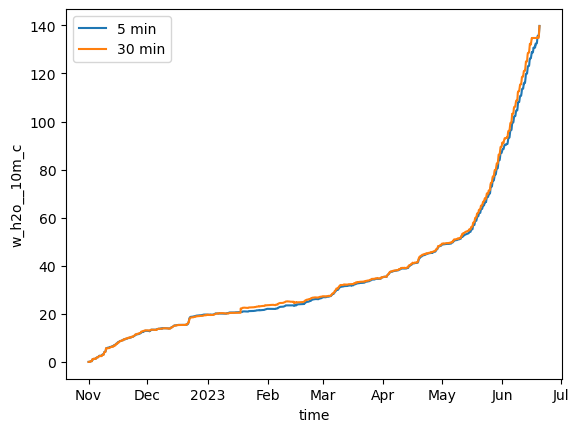

In [38]:
fig, ax = plt.subplots()
(sos_ds5min['w_h2o__10m_c'].cumsum()*60*5/density_water.magnitude).plot(ax=ax, label='5 min')
(sos_ds['w_h2o__10m_c'].cumsum()*60*30/density_water.magnitude).plot(ax=ax, label='30 min')
plt.legend()

# Add additional variables

## Add snow depth

Open snow depth data

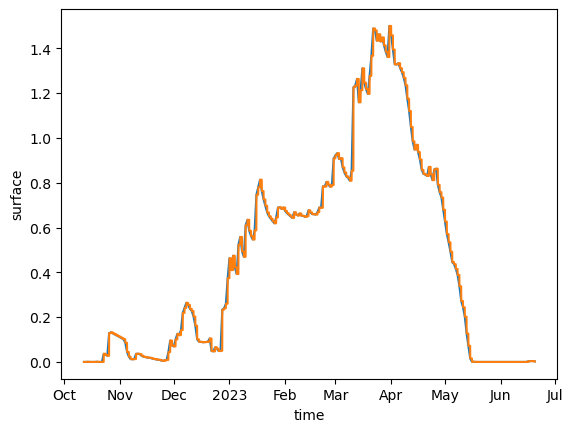

In [39]:
towerc_snowdepth_dataset = xr.open_dataset("~/Development/data/sublimationofsnow/lidar_snow_depth/C_l2.nc")
towerc_lidar_snowdepth_da = towerc_snowdepth_dataset.resample(time='1440Min').median()['surface']
towerc_lidar_snowdepth_da = towerc_lidar_snowdepth_da.interpolate_na(dim = 'time', method='linear')
towerc_lidar_snowdepth_da = towerc_lidar_snowdepth_da.where(towerc_lidar_snowdepth_da > 0, 0)
towerc_lidar_snowdepth_upsample_da = towerc_lidar_snowdepth_da.resample(time = '30Min').pad()
towerc_lidar_snowdepth_da.plot()
towerc_lidar_snowdepth_upsample_da.plot()
plt.show()

In [40]:
towerc_snowdepth_df = towerc_lidar_snowdepth_upsample_da.loc[
    sos_ds.time.min():sos_ds.time.max()
].to_dataframe()
towerc_snowdepth_df = towerc_snowdepth_df.reset_index()
sos_ds['SnowDepth_c'] = (['time'],  towerc_snowdepth_df.surface.values)

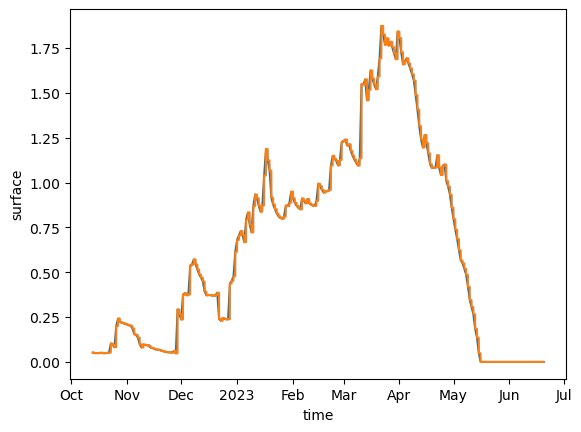

In [41]:
towerd_snowdepth_dataset = xr.open_dataset("~/Development/data/sublimationofsnow/lidar_snow_depth/D_from_D_l6.nc")
towerd_lidar_snowdepth_da = towerd_snowdepth_dataset.resample(time='1440Min').median()['surface']
towerd_lidar_snowdepth_da = towerd_lidar_snowdepth_da.interpolate_na(dim = 'time', method='linear')
towerd_lidar_snowdepth_da = towerd_lidar_snowdepth_da.where(towerd_lidar_snowdepth_da > 0, 0)
towerd_lidar_snowdepth_upsample_da = towerd_lidar_snowdepth_da.resample(time = '30Min').pad()
towerd_lidar_snowdepth_da.plot()
towerd_lidar_snowdepth_upsample_da.plot()
plt.show()

In [42]:
towerd_snowdepth_df = towerd_lidar_snowdepth_upsample_da.loc[
    sos_ds.time.min():sos_ds.time.max()
].to_dataframe()
towerd_snowdepth_df = towerd_snowdepth_df.reset_index()
sos_ds['SnowDepth_d'] = (['time'],  towerd_snowdepth_df.surface.values)

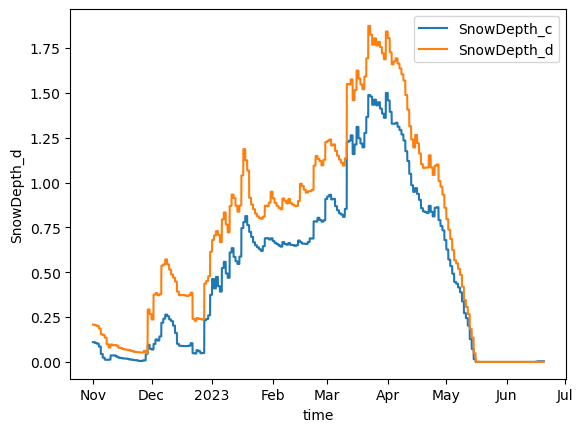

In [43]:
sos_ds['SnowDepth_c'].plot(label='SnowDepth_c')
sos_ds['SnowDepth_d'].plot(label='SnowDepth_d')
plt.legend()

## Add/calculate longwave radiation and surface temperatures

In [44]:
sos_ds = variables.add_longwave_radiation(sos_ds)
sos_ds = variables.add_surface_temps(sos_ds)

### Clean $T_s$ variables before proceeding with other calculations

(as of Feb 20, 2023, using NCAR's QC data release, we found a single $T_s$ outlier.)

In [45]:
Tsurf_vars = [v for v in sos_ds.data_vars if v.startswith('Tsurf')]
Tsurf_vars

['Tsurf_rad_d',
 'Tsurf_c',
 'Tsurf_d',
 'Tsurf_ue',
 'Tsurf_uw',
 'Tsurfplanck_c',
 'Tsurfplanck_d',
 'Tsurfplanck_ue',
 'Tsurfplanck_uw']

In [46]:
for var in Tsurf_vars:
    print(f"{var}\t {round(sos_ds[var].min().item(), 1)}\t{round(sos_ds[var].max().item(), 1)}")

Tsurf_rad_d	 -30.2	33.4
Tsurf_c	 -78.7	69.3
Tsurf_d	 -84.7	222.2
Tsurf_ue	 -70.1	102.6
Tsurf_uw	 -32.0	171.9
Tsurfplanck_c	 -79.1	69.3
Tsurfplanck_d	 -85.1	223.2
Tsurfplanck_ue	 -70.5	102.8
Tsurfplanck_uw	 -32.3	172.5


In [47]:
for var in Tsurf_vars:
    sos_ds[var] = sos_ds[var].where(
        (sos_ds[var].values > -40)
        &
        (sos_ds[var].values < 40)
    ).interpolate_na(
        dim='time', 
        method='linear'
    ).where(
        ~ sos_ds[var].isnull()
    )

In [48]:
for var in Tsurf_vars:
    print(f"{var}\t {round(sos_ds[var].min().item(), 1)}\t{round(sos_ds[var].max().item(), 1)}")


Tsurf_rad_d	 -30.2	33.4
Tsurf_c	 -32.5	38.1
Tsurf_d	 -32.6	33.8
Tsurf_ue	 -32.0	40.0
Tsurf_uw	 -32.0	39.9
Tsurfplanck_c	 -32.8	38.0
Tsurfplanck_d	 -32.9	33.7
Tsurfplanck_ue	 -32.3	39.9
Tsurfplanck_uw	 -32.3	39.8


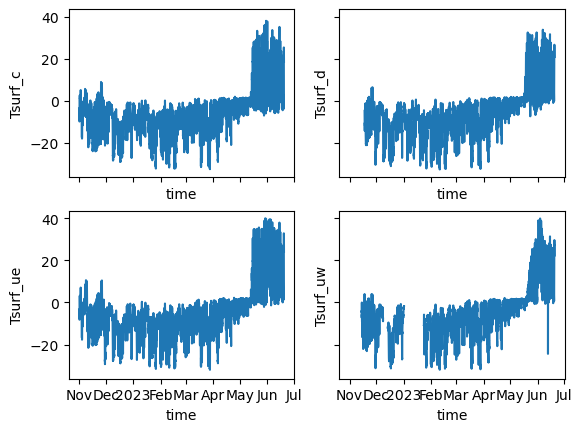

In [49]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True)
sos_ds['Tsurf_c'].plot(ax=axes[0][0])
sos_ds['Tsurf_d'].plot(ax=axes[0][1])
sos_ds['Tsurf_ue'].plot(ax=axes[1][0])
sos_ds['Tsurf_uw'].plot(ax=axes[1][1])

## Add $T_v, \theta, \theta_v, \textbf{tke}, R_i, L$

In [50]:
sos_ds = variables.add_potential_virtual_temperatures(sos_ds)
sos_ds = variables.add_surface_potential_virtual_temperatures(sos_ds)
sos_ds = variables.add_tke(sos_ds)
sos_ds = variables.add_gradients_and_ri(sos_ds)
sos_ds = variables.add_shear_velocity_and_obukhov_length(sos_ds)

/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/sublimpy/gradients.py:126: OptimizeWarning: Covariance of the parameters could not be estimated
  [a,b,c], _ = curve_fit(LogPolynomial.function, heights, values)
/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/sublimpy/gradients.py:126: OptimizeWarning: Covariance of the parameters could not be estimated
  [a,b,c], _ = curve_fit(LogPolynomial.function, heights, values)
/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/sublimpy/gradients.py:126: OptimizeWarning: Covariance of the parameters could not be estimated
  [a,b,c], _ = curve_fit(LogPolynomial.function, heights, values)
/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/sublimpy/gradients.py:126: OptimizeWarning: Covariance of the parameters could not be estimated
  [a,b,c], _ = curve_fit(LogPolynomial.function, heights, values)
/Users/elischwat/miniforge3/envs

## Add decoupling metric, from Peltola et al. (2021).

We adjust the height value for snow depth.

In [51]:
def decoupling_metric(z, sigma_w, N):
    """Calculate the decoupling metric as described in Peltola et al (2021).

    Peltola, O., Lapo, K., & Thomas, C. K. (2021). A Physics‐Based Universal Indicator for Vertical Decoupling and Mixing Across Canopies Architectures and Dynamic Stabilities. Geophysical Research Letters, 48(5), e2020GL091615. https://doi.org/10.1029/2020GL091615
    
    Args:
        z (float): height of measurements 
        sigma_w (float): standarad deviation of w, vertical velocity
        N (float): Brunt-Vaisala frequency
    """
    # Brunt Vaisala frequency estimated using the bulk theta gradient
    # N = np.sqrt(
    #     g * (theta_e - theta_mean) / theta_mean
    # )

    Lb = sigma_w / N
    omega = Lb / ( np.sqrt(2)*z )
    return omega


In [52]:
#######################################################################
### OLD METHOD USING GRADIENT-BASED N
#######################################################################
from metpy.calc import brunt_vaisala_frequency

sigma_w = np.sqrt(sos_ds['w_w__3m_c']).values
pot_temps = sos_ds[[
    'Tpot_2m_c', 
    'Tpot_3m_c', 
    'Tpot_4m_c', 
    'Tpot_5m_c', 
    'Tpot_6m_c'
]].to_stacked_array(
    'z', ['time']
).values

snow_depth_values = sos_ds['SnowDepth_c']
snow_depth_values_reshaped = np.repeat(sos_ds['SnowDepth_c'].values, 5).reshape(-1, 5)

heights = np.full(pot_temps.shape,  [ 2,    3,    4,    5,    6])
heights_adjusted = heights - snow_depth_values_reshaped
brunt_vaisala_values = [ Ns[1] for Ns in 
    brunt_vaisala_frequency( 
        heights_adjusted * units("meters"),
        pot_temps * units("celsius"), 
        vertical_dim=1
    ).magnitude   
]
z = np.full(sigma_w.shape, 3) - snow_depth_values.values

# decoupling_metric(z, sigma_w, N)
print(len(z))
print(len(sigma_w))
print(len(brunt_vaisala_values))

omegas = decoupling_metric(z, sigma_w, brunt_vaisala_values)
sos_ds['omega_3m_c'] = (['time'],  omegas)
print(len(omegas))



#######################################################################
### NEW METHOD USING BULK N
#######################################################################
# sigma_w = np.sqrt(sos_ds['w_w__3m_c']).values

# snow_depth_values = sos_ds['SnowDepth_c'].values

# air_temp_height = 3
# heights_adjusted = air_temp_height - snow_depth_values
# surf_pottemp = sos_ds['Tsurfpot_c'].values
# air_pottemp = sos_ds['Tpot_3m_c'].values
# surfacealyer_avg_pottemp = 0.5*(air_pottemp + surf_pottemp)
# bulk_brunt_vaisala_value = np.sqrt(
#     metpy.constants.earth_gravity.magnitude.item()*(air_pottemp - surfacealyer_avg_pottemp) 
#     /
#     (surfacealyer_avg_pottemp * heights_adjusted)
# )
# z = np.full(sigma_w.shape, 3) - snow_depth_values

# # decoupling_metric(z, sigma_w, N)
# print(len(z))
# print(len(sigma_w))
# print(len(bulk_brunt_vaisala_value))

# omegas = decoupling_metric(z, sigma_w, bulk_brunt_vaisala_value)
# sos_ds['omega_3m_c'] = (['time'],  omegas)

11088
11088
11088
11088


/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77483/56407381.py:16: RuntimeWarning: divide by zero encountered in divide
  Lb = sigma_w / N


(0.0, 1.0)

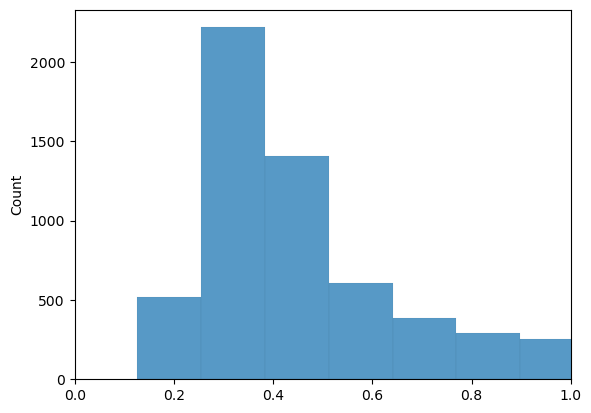

In [53]:
import seaborn as sns
sns.histplot(sos_ds['omega_3m_c'])
plt.xlim(0,1)

## Net LW and Net SW

In [54]:
sos_ds['Rlw_net_9m_d'] = sos_ds['Rlw_in_9m_d'] - sos_ds['Rlw_out_9m_d']
sos_ds['Rsw_net_9m_d'] = sos_ds['Rsw_in_9m_d'] - sos_ds['Rsw_out_9m_d']

sos_ds['Rlw_net_9m_uw'] = sos_ds['Rlw_in_9m_uw'] - sos_ds['Rlw_out_9m_uw']

## Net Radiation

In [55]:
sos_ds['Rnet_9m_d'] = (
    (sos_ds['Rsw_in_9m_d'] + sos_ds['Rlw_in_9m_d'])
    -
    (sos_ds['Rsw_out_9m_d'] + sos_ds['Rlw_out_9m_d'])
)

## Specific humidity

In [56]:
for var in [
    'Tsurfmixingratio_c',
    'mixingratio_1m_c',
    'mixingratio_2m_c',
    'mixingratio_3m_c',
    'mixingratio_4m_c',
    'mixingratio_5m_c',
    'mixingratio_6m_c',
    'mixingratio_7m_c',
    'mixingratio_8m_c',
    'mixingratio_9m_c',
    'mixingratio_10m_c',
    'mixingratio_11m_c',
    'mixingratio_12m_c',
    'mixingratio_13m_c',
    'mixingratio_14m_c',
    'mixingratio_15m_c',
    'mixingratio_16m_c',
    'mixingratio_17m_c',
    'mixingratio_18m_c',
    'mixingratio_19m_c',
    'mixingratio_20m_c',
]:
    new_var_name = var.replace('mixingratio', 'specifichumidity')
    result = specific_humidity_from_mixing_ratio(
        sos_ds[var]*units('g/g')
    )
    sos_ds[new_var_name] = (['time'], result.values)
    sos_ds[new_var_name] = sos_ds[new_var_name].assign_attrs(units=str(result.pint.units))

# Apply sensible and latent heat flux corrections (lots of citations, see here: https://www.eol.ucar.edu/content/corrections-sensible-and-latent-heat-flux-measurements)

In [57]:
# rho_d = 1293*units('g/m^3') # density of dry air
# rho_a = 1287*units('g/m^3') #density of moist air
# rho_v = 600*units('g/m^3') #density of water vapor
# mu = 1/0.622
# rho_w = metpy.constants.density_water

# def corrected_sensible_heat_flux(
#     w_tc_, #sonic_temperature_flux
#     w_h2o_, #h2o_flux
#     Q, #specific_humidity
#     T, #absolute_temperature
#     A, #A
#     Mr, #mean_mixing_ratio
# ):
#     Ctc = 0.51*(1 + Q*(mu-1))
#     part1 = w_tc_ - Ctc*(T/rho_a)*A*w_h2o_
#     part2 = 1 + Ctc*Q
#     return part1 / part2

# def corrected_latent_heat_flux(
#     w_tc_, #sonic_temperature_flux
#     w_h2o_, #h2o_flux
#     Q, #specific_humidity
#     T, #absolute_temperature
#     A, #A
#     Mr, #mean_mixing_ratio
# ):
#     Ctc = 0.51*(1 + Q*(mu-1))
#     return (1 + mu*Mr)* (
#         (A/rho_d)*w_h2o_ + (Mr/T)*(w_tc_)
#     ) / (
#         1 + Ctc*Q
#     )

# def wpl_corrected_latent_heat_flux(
#     w_tc_, #sonic_temperature_flux
#     w_h2o_, #h2o_flux
#     Q, #specific_humidity
#     T, #absolute_temperature
#     A, #A
#     Mr, #mean_mixing_ratio
# ):
#     return (
#         1 + mu*Mr
#     )*(
#         w_h2o_ + (rho_v/T)*w_tc_
#     )

In [58]:
# sos_ds['w_tc__3m_c_corrected'] = corrected_sensible_heat_flux(
#     sos_ds['w_tc__3m_c']*units("(m/s)(degK)"),
#     sos_ds['w_h2o__3m_c']*units("(m/s)(g/m^3)"),
#     sos_ds['specifichumidity_3m_c']*units("g/g"),
#     sos_ds['T_3m_c'] * units.degK,
#     1, #A
#     sos_ds['mixingratio_3m_c']*units("g/g")
# )
# sos_ds['w_h2o__3m_c_corrected'] = rho_d*corrected_latent_heat_flux(
#     sos_ds['w_tc__3m_c']*units("(m/s)(degC)"),
#     sos_ds['w_h2o__3m_c']*units("(m/s)(g/m^3)"),
#     sos_ds['specifichumidity_3m_c']*units("g/g"),
#     sos_ds['T_3m_c'] * units.degC,
#     1, #A
#     sos_ds['mixingratio_3m_c']*units("g/g")
# )

# # WHY DO I HAVE TO MULTIPLE DENSITY_WATER HERE???
# sos_ds['w_h2o__3m_c_wplcorrected'] = wpl_corrected_latent_heat_flux(
#     sos_ds['w_tc__3m_c']*units("(m/s)(degC)"),
#     sos_ds['w_h2o__3m_c']*units("(m/s)(g/m^3)"),
#     sos_ds['specifichumidity_3m_c']*units("g/g"),
#     sos_ds['T_3m_c'] * units.degC,
#     1, #A
#     sos_ds['mixingratio_3m_c']*units("g/g")
# )

In [59]:
# (sos_ds['w_h2o__3m_c']).sel(time=slice('20221201', '20221215')).plot(label="Measured")
# (-0.1*sos_ds['w_h2o__3m_c_corrected']).sel(time=slice('20221201', '20221215')).plot(label='Corrected')
# plt.legend()

In [60]:
# (
#     (sos_ds['w_tc__3m_c'] - sos_ds['w_tc__3m_c_corrected'].pint.magnitude)/sos_ds['w_tc__3m_c']
# ).sel(time=slice('20221201', '20221215')).plot(label="∆ w_tc_ (meas-corr)/meas")
# # plt.ylim(-100,100)
# plt.legend()

In [61]:
# (
#     (sos_ds['w_h2o__3m_c'] - sos_ds['w_h2o__3m_c_corrected'].pint.magnitude)/sos_ds['w_h2o__3m_c']
# ).sel(time=slice('20221201', '20221215')).plot(label="∆ w_q_ (meas-corr)/meas")
# plt.ylim(-200,200)
# plt.legend()

In [62]:
# sos_ds['w_tc__3m_c'].sel(time=slice('20221201', '20221215')).plot()
# sos_ds['w_tc__3m_c_corrected'].sel(time=slice('20221201', '20221215')).plot()

# Get Tidy Dataset

In [63]:
from sublimpy import tidy

In [64]:
tidy_df = tidy.get_tidy_dataset(sos_ds, list(sos_ds.data_vars))

Which variables did not get a "measurement" name assigned?

In [65]:
variables_with_no_measurement = tidy_df[tidy_df.measurement.apply(lambda x: x is None)].variable.unique()
variables_with_no_measurement

array(['Rpile_out_9m_d', 'Tcase_out_9m_d', 'Rpile_in_9m_d',
       'Tcase_in_9m_d', 'Tcase_uw', 'Rpile_in_uw', 'Rpile_out_uw',
       'snowfall_mask', 'Tsurfdryairdensity_rad_d',
       'Tsurfdryairdensity_c'], dtype=object)

In [66]:
set(tidy_df.variable.unique()).difference(set(list(sos_ds.data_vars)))

set()

In [67]:
import pandas as pd
import altair as alt
seconds_in_timestep = 60*30
density_water = 1000
from sublimpy import utils
tidy_df_localized = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')
tidy_df_localized = tidy_df_localized[
    (tidy_df_localized.time > '20221130')
    &
    (tidy_df_localized.time < '20230509')
]

measured_results_mm = tidy_df_localized[tidy_df_localized.variable.isin([
    'w_h2o__2m_c',
    'w_h2o__3m_c',
    'w_h2o__5m_c',
    'w_h2o__10m_c',
    'w_h2o__15m_c',
    'w_h2o__20m_c',

    'w_h2o__3m_ue',
    'w_h2o__10m_ue',

    'w_h2o__3m_uw',
    'w_h2o__10m_uw',

    'w_h2o__3m_d',
    'w_h2o__10m_d',
])][
    ['time', 'value', 'variable']
]
measured_results_mm.columns = ['time', 'measured', 'variable']
measured_results_mm = measured_results_mm.pivot(
    index = 'time',
    columns = 'variable',
    values = 'measured'
)
# convert to mm
measured_results_mm = measured_results_mm*seconds_in_timestep/density_water
measured_results_cumsum = measured_results_mm.cumsum().reset_index()
measured_results_cumsum = measured_results_cumsum.melt(id_vars='time')
measured_results_cumsum['height'] = measured_results_cumsum['variable'].apply(lambda s: int(s.split('__')[1].split('m')[0]))
measured_results_cumsum['tower'] = measured_results_cumsum['variable'].apply(lambda s: s.split('__')[1].split('_')[-1])
measured_results_cumsum['tower-height'] = measured_results_cumsum['tower'] + '-' + measured_results_cumsum['height'].astype('str')
measured_results_cumsum


src = measured_results_cumsum.groupby(['height', 'tower'])[['value']].max().reset_index()
sublimation_totals_per_height_tower_chart = alt.Chart(src).mark_point(size=100).encode(
    alt.Y("height:O").sort('-y').title("height (m)"),
    alt.X("value:Q").scale(zero=False).title(["Seasonal sublimation (mm SWE)"]),
    # alt.Color("height:O").scale(scheme='turbo').legend(columns=2),
    alt.Shape("tower:N")
).properties(width = 150, height = 150)
sublimation_totals_per_height_tower_chart

alt.Chart(...)

# Save dataset

In [68]:
ls -lah | grep parquet

-rw-r--r--@    1 elischwat  staff   202M Apr  3  2024 coare_model_results.parquet
-rw-r--r--@    1 elischwat  staff   116M Mar  6  2024 model_results.parquet
-rw-r--r--@    1 elischwat  staff   138M Sep 12 14:53 tidy_df_10min.parquet
-rw-r--r--     1 elischwat  staff    57M Jul 30 15:16 tidy_df_20221101_20230619_noplanar_fit.parquet
-rw-r--r--     1 elischwat  staff    57M Jul 18 15:41 tidy_df_20221101_20230619_planar_fit.parquet
-rw-r--r--@    1 elischwat  staff    57M Aug 21 14:30 tidy_df_20221101_20230619_planar_fit_multiplane.parquet
-rw-r--r--@    1 elischwat  staff    57M Oct  2 14:09 tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP.parquet
-rw-r--r--@    1 elischwat  staff    56M Oct  4 11:57 tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_dispiked.parquet
-rw-r--r--     1 elischwat  staff    54M Oct 10 10:50 tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_nodespiking_flags3600.parquet
-rw-r--r--@    1 elischwat  staff    55M Oct 10 10:41 tidy_df_

In [69]:
if PLANAR_FIT:    
    if 'oneplane' in planar_fitted_dir:
        if FILTER_SNOWFALL:
            tidy_df.to_parquet(
                f'tidy_df_{start_date}_{end_date}_planar_fit_STRAIGHTUP_{filtering_str}_flags{PERCENTAGE_DIAG}_snowfallfiltered{snowfall_mask_str}.parquet', 
                index=False
            )
        else:
            tidy_df.to_parquet(
                f'tidy_df_{start_date}_{end_date}_planar_fit_STRAIGHTUP_{filtering_str}_flags{PERCENTAGE_DIAG}.parquet', 
                index=False
            )
    else:
        if FILTER_SNOWFALL:
            tidy_df.to_parquet(
                f'tidy_df_{start_date}_{end_date}_planar_fit_multiplane_STRAIGHTUP_{filtering_str}_flags{PERCENTAGE_DIAG}_snowfallfiltered{snowfall_mask_str}.parquet', index=False)
        else:
            tidy_df.to_parquet(
                f'tidy_df_{start_date}_{end_date}_planar_fit_multiplane_STRAIGHTUP_{filtering_str}_flags{PERCENTAGE_DIAG}.parquet', index=False)
else:
    if FILTER_SNOWFALL:
        tidy_df.to_parquet(
            f'tidy_df_{start_date}_{end_date}_noplanar_fit_STRAIGHTUP_{filtering_str}_flags{PERCENTAGE_DIAG}_snowfallfiltered{snowfall_mask_str}.parquet', 
            index=False
        )
    else:
        tidy_df.to_parquet(
            f'tidy_df_{start_date}_{end_date}_noplanar_fit_STRAIGHTUP_{filtering_str}_flags{PERCENTAGE_DIAG}.parquet', 
            index=False
        )

In [70]:
ls -lah | grep parquet

-rw-r--r--@    1 elischwat  staff   202M Apr  3  2024 coare_model_results.parquet
-rw-r--r--@    1 elischwat  staff   116M Mar  6  2024 model_results.parquet
-rw-r--r--@    1 elischwat  staff   138M Sep 12 14:53 tidy_df_10min.parquet
-rw-r--r--     1 elischwat  staff    57M Jul 30 15:16 tidy_df_20221101_20230619_noplanar_fit.parquet
-rw-r--r--     1 elischwat  staff    57M Jul 18 15:41 tidy_df_20221101_20230619_planar_fit.parquet
-rw-r--r--@    1 elischwat  staff    57M Aug 21 14:30 tidy_df_20221101_20230619_planar_fit_multiplane.parquet
-rw-r--r--@    1 elischwat  staff    57M Oct  2 14:09 tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP.parquet
-rw-r--r--@    1 elischwat  staff    56M Oct  4 11:57 tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_dispiked.parquet
-rw-r--r--     1 elischwat  staff    54M Oct 10 10:50 tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_nodespiking_flags3600.parquet
-rw-r--r--@    1 elischwat  staff    55M Oct 10 10:41 tidy_df_

In [94]:
pd.read_parquet(
    "tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_nodespiking_flags36000.parquet"
).query("variable == 'w_h2o__20m_c'").set_index('time')['value'].value_counts()

value
 0.000000    905
 0.008617      1
 0.000190      1
 0.004404      1
 0.001110      1
            ... 
-0.000764      1
-0.000837      1
-0.000039      1
 0.000473      1
 0.097762      1
Name: count, Length: 9675, dtype: int64

In [95]:
pd.read_parquet(
    "tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_nodespiking_flags36000_snowfallfiltered0mm.parquet"
).query("variable == 'w_h2o__20m_c'").set_index('time')['value'].value_counts()

value
 0.000000    953
-0.001045      1
 0.001989      1
 0.005508      1
 0.008222      1
            ... 
 0.000635      1
 0.001230      1
-0.000235      1
-0.001105      1
 0.097762      1
Name: count, Length: 9634, dtype: int64

In [71]:
# sos_ds['w_h2o__3m_c'].loc['20221221':'20221223'].plot(label='w_h2o__3m_c')
# sos_ds['w_h2o__5m_c'].loc['20221221':'20221223'].plot(label='w_h2o__5m_c')
# sos_ds['w_h2o__10m_c'].loc['20221221':'20221223'].plot(label='w_h2o__10m_c')
# sos_ds['w_h2o__15m_c'].loc['20221221':'20221223'].plot(label='w_h2o__15m_c')
# sos_ds['w_h2o__20m_c'].loc['20221221':'20221223'].plot(label='w_h2o__20m_c')
# plt.legend()

In [72]:
# ls -lah | grep parquet

In [73]:
# df1 = pd.read_parquet('tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP.parquet')
# df2 = pd.read_parquet('tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_dispiked.parquet')

In [74]:
# src1 = df1[
#     ~df1.variable.str.contains('predicted')
# ].query("measurement == 'w_h2o_'").query("tower == 'c'").query("height > 1")

# src2 = df2[
#     ~df2.variable.str.contains('predicted')
# ].query("measurement == 'w_h2o_'").query("tower == 'c'").query("height > 1")

In [75]:
# alt.Chart(
#     src1[src1.time < '20221222'][src1.time > '20221220']
# ).mark_line().encode(
#     alt.X('time:T'),
#     alt.Y('value:Q'),
#     alt.Color('height:O')
# ) | alt.Chart(
#     src2[src2.time < '20221222'][src2.time > '20221220']
# ).mark_line().encode(
#     alt.X('time:T'),
#     alt.Y('value:Q'),
#     alt.Color('height:O')
# ).interactive()

# TEST DESPIKING DIFFERENCES

In [76]:
# import glob
# COLUMNS = [
#     'w_h2o__2m_c_fit', 'w_h2o__3m_c_fit', 'w_h2o__5m_c_fit', 'w_h2o__10m_c_fit', 'w_h2o__15m_c_fit', 'w_h2o__20m_c_fit',
#     'w_h2o__3m_d_fit', 'w_h2o__10m_d_fit',
#     'w_h2o__3m_ue_fit', 'w_h2o__10m_ue_fit',
#     'w_h2o__3m_uw_fit', 'w_h2o__10m_uw_fit',
# ]
# srcq3 = pd.read_parquet(glob.glob("/Users/elischwat/Development/data/sublimationofsnow/planar_fit_processed_30min_despiked_q3.5/**.parquet"), columns=COLUMNS).sort_index()
# srcq7 = pd.read_parquet(glob.glob("/Users/elischwat/Development/data/sublimationofsnow/planar_fit_processed_30min_despiked_q7/**.parquet"), columns=COLUMNS).sort_index()
# srcraw = pd.read_parquet(glob.glob("/Users/elischwat/Development/data/sublimationofsnow/planar_fit_processed_30min/**.parquet"), columns=COLUMNS).sort_index()

# def organize_processed_lhflux_datasets(planar_fitted_data_df): 
#     planar_fitted_data_df = planar_fitted_data_df[[c for c in planar_fitted_data_df.columns if c.endswith('_fit')]]
#     planar_fitted_data_df.columns = [c.replace('_fit', '') for c in planar_fitted_data_df.columns]
#     planar_fitted_data_df.index = planar_fitted_data_df.index - dt.timedelta(minutes=15)
#     return planar_fitted_data_df

# srcq3 = organize_processed_lhflux_datasets(srcq3).assign(processing = 'q3')
# srcq7 = organize_processed_lhflux_datasets(srcq7).assign(processing = 'q7')
# srcraw = organize_processed_lhflux_datasets(srcraw).assign(processing = 'raw')
# src = pd.concat([srcq3, srcq7, srcraw])

# # src = utils.modify_df_timezone(src.reset_index('time'), 'UTC', 'US/Mountain').set_index('time')

In [77]:
# print(srcraw.index.max(), srcraw.index.min())
# print(srcq7.index.max(), srcq7.index.min())
# print(srcq3.index.max(), srcq3.index.min())

In [78]:
# print(round(srcraw['w_h2o__10m_d'].mean(), 5), round(srcraw['w_h2o__10m_d'].min(), 5), round(srcraw['w_h2o__10m_d'].max(), 5))
# print(round(srcq7['w_h2o__10m_d'].mean(), 5), round(srcq7['w_h2o__10m_d'].min(), 5), round(srcq7['w_h2o__10m_d'].max(), 5))
# print(round(srcq3['w_h2o__10m_d'].mean(), 5), round(srcq3['w_h2o__10m_d'].min(), 5), round(srcq3['w_h2o__10m_d'].max(), 5))

In [79]:
# local = src.copy()
# vars = [C.replace('_fit', '') for C in COLUMNS]
# local = local.sort_index().loc['20221130': '20230508']
# local[vars] = local.groupby('processing')[vars].cumsum()
# alt.Chart(
#     local.reset_index()
# ).transform_fold(
#     vars
# ).mark_line().encode(
#     alt.X('time:T'),
#     alt.Y('value:Q'),
#     alt.Row('key:N'),
#     alt.Color('processing').sort(['raw', 'q7', 'q3'])
# ).properties(width=600, height = 200).resolve_scale(x='independent').interactive()

In [80]:
# local = src.copy()
# vars = [C.replace('_fit', '') for C in COLUMNS]
# local = local.loc['20221221': '20221222']
# alt.Chart(
#     local.reset_index()
# ).transform_fold(
#     vars
# ).mark_line().encode(
#     alt.X('time:T'),
#     alt.Y('value:Q'),
#     alt.Row('key:N'),
#     alt.Color('processing').sort(['raw', 'q7', 'q3'])
# ).properties(width=600, height = 200).interactive()

In [81]:
# local = src.copy()
# vars = [C.replace('_fit', '') for C in COLUMNS]
# local = local.loc['20230110': '20230112']
# alt.Chart(
#     local.reset_index()
# ).transform_fold(
#     vars
# ).mark_line().encode(
#     alt.X('time:T'),
#     alt.Y('value:Q'),
#     alt.Row('key:N'),
#     alt.Color('processing').sort(['raw', 'q7', 'q3'])
# ).properties(width=600, height = 200).interactive()

In [82]:
# srcq3 = srcq3.sort_index().loc[:srcq3.index.max()]
# srcq7 = srcq7.sort_index().loc[:srcq3.index.max()]
# srcraw = srcraw.sort_index().loc[:srcq3.index.max()]


In [83]:
# seconds_in_timestep = 60*30
# density_water = 1000
# # convert to mm
# def convert_to_mm_cumsum(src):
#     measured_results_mm = src.drop(columns='processing')*seconds_in_timestep/density_water
#     measured_results_cumsum = measured_results_mm.cumsum().reset_index()
#     measured_results_cumsum = measured_results_cumsum.melt(id_vars='time')
#     measured_results_cumsum['height'] = measured_results_cumsum['variable'].apply(lambda s: int(s.split('__')[1].split('m')[0]))
#     measured_results_cumsum['tower'] = measured_results_cumsum['variable'].apply(lambda s: s.split('__')[1].split('_')[-1])
#     measured_results_cumsum['tower-height'] = measured_results_cumsum['tower'] + '-' + measured_results_cumsum['height'].astype('str')
#     return measured_results_cumsum

# measured_results_cumsum_q3 = convert_to_mm_cumsum(srcq3.loc['20221130': '20230508']).groupby(['height', 'tower'])[['value']].max().reset_index()
# measured_results_cumsum_q7 = convert_to_mm_cumsum(srcq7.loc['20221130': '20230508']).groupby(['height', 'tower'])[['value']].max().reset_index()
# measured_results_cumsum_raw = convert_to_mm_cumsum(srcraw.loc['20221130': '20230508']).groupby(['height', 'tower'])[['value']].max().reset_index()

In [84]:
# def seasonal_total_chart(src):
#     return alt.Chart(src).mark_point(size=100).encode(
#         alt.Y("height:O").sort('-y').title("height (m)"),
#         alt.X("value:Q").scale(zero=False).title(["Seasonal sublimation (mm SWE)"]),
#         # alt.Color("height:O").scale(scheme='turbo').legend(columns=2),
#         alt.Shape("tower:N")
#     ).properties(width = 200, height = 100)

# (
# seasonal_total_chart(measured_results_cumsum_q3).properties(title='Despiked (q = 3, strict)') &\
# seasonal_total_chart(measured_results_cumsum_q7).properties(title='Despiked (q = 7, standard)') &\
# seasonal_total_chart(measured_results_cumsum_raw).properties(title='Raw, (no despiking)')
# ).resolve_scale(y='shared', x='shared')